# Consistency between the raster and vector versions of the Randolph Glacier Inventory (RGI) dataset in the context of glaciological and hydrological applications

Production date: 31-05-2025

Dataset version: 7.0

Produced by: Yoni Verhaegen and Philippe Huybrechts (Vrije Universiteit Brussel)

## 🌍 Use case: Assessing the spatial distribution of glaciers and the total glacier area in the context of water resource management at the local, regional, and global scale

## ❓ Quality assessment question
* **"How do glacier areas calculated from vector data compare to those calculated from the raster version of the data, and what does this comparison reveal about the quality and consistency of the glacier extent dataset?"**

Glaciers are a major contributor to current global sea-level rise, a resource of fresh water, a potential threat of natural hazards, an important factor for hydro-power production, recreation and tourism. A proper assessment of glacier areas, glacier characteristics, as well as their changes due to warming climatic conditions therefore plays a crucial role in dealing with these issues. In that regard, the "[Glaciers distribution data from the Randolph Glacier Inventory (RGI) for year 2000](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview)" (here we use version 7.0) dataset on the Climate Data Store (CDS) provides key information with respect to glacier extent and their characteristics. The RGI v7.0 dataset, available on the Climate Data Store, is the most comprehensive global dataset for glacier outlines around the year 2000, offering both vector (polygon) and raster (gridded) formats. The RGI dataset is a collection of digital glacier and ice cap outlines at the global scale, nominally provided for the year 2000 [[1](https://www.glims.org/RGI/randolph60.html), [2](https://doi.org/10.3189/2014JoG13J176)]. The data are available in both vector (a shapefile with polygons of individual glacier outlines) and raster (as gridded data with the aggregated fractional glacier areas per pixel) format. As it is the most complete dataset of glacier extent data with a global coverage, researchers often take this data to represent the current state of all glaciers. This notebook investigates the dataset's consistency by comparing the total regional and global glacier surface area between the vector (polygons) and raster (gridded data) version of the data. 

## 📢 Quality assessment statements

```{admonition} These are the key outcomes of this assessment
:class: note
- Glacier area data in the RGI dataset are present in both vector (polygons) and raster (gridded) formats. The primary goal of RGI is to provide consistent, static glacier outlines for climatological, hydrological, and glaciological applications at regional to global scales. It is not primarily intended for localized studies (e.g. for single, individual glaciers) or for glacier area change detection. Glacier outlines at such larger spatial scales can hence serve as baseline input for key applications such as mass balance or run-off modeling, ice thickness estimates, and climate sensitivity assessments. In that regard, the vector version of the dataset contains the data in polygon format (i.e. shape files for Geographic Information Systems), but the raster data are typically more practical for modelling efforts. 
- While both formats are suitable for visualizing and quantifying glacier areas at local, regional, and global scales, the raster data require users to calculate absolute glacier areas from fractional values without the corresponding absolute surface area of a certain grid cell provided. Even though the resulting total regional/global glacier areas in both data formats agree relatively well, notable discrepancies between the two formats exist in some regions (particularly in the southern Asian/Himalayan region). These differences (partly) arise from methodological differences in calculating absolute glacier areas in both product versions. Global area differences may arise due to the spherical Earth assumption when calculating absolute glacier areas for the raster dataset in this notebook, while regional differences could be caused by a misassignment of coarse raster pixels to an incorrect bordering RGI region.
```

## 📋 Methodology

### Dataset description

The dataset of the glaciers distribution on the Climate Data Store (CDS) is an almost complete collection of digital glacier and ice cap outlines and their geometrical/hypsometrical characteristics from various data sources at the global scale [[1](https://www.glims.org/RGI/randolph60.html), [2](https://doi.org/10.3189/2014JoG13J176)]. The dataset on the CDS is considered a snapshot of glacier outlines around the year 2000, assembled mainly from satellite images, and is based on the Randolph Glacier Inventory (RGI), which is currently the most complete dataset of glacier outlines. Simply stated, the glaciers in the dataset were automatically classified using the distinctive spectral reflectance signatures of bedrock, snow and ice. During post-processing, raw glacier outlines are quality checked and manually corrected if required (e.g. in the case of a supraglacial debris cover). The vector part of the dataset divides the glaciers into separate RGI regions, i.e. there are 19 of those regions ("clusters" of glaciers) in RGIv7.0. The raster version of the data contains aggregated fractional glacier areas for each pixel of 1 by 1 degree but does not provide sufficient information to classify glaciers into distinct RGI regions. For a more detailed description of the data acquisition and processing methods, we refer to the [documentation on the CDS](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview) and the [ECMWF Confluence Wiki](https://confluence.ecmwf.int/display/CKB/Glacier+Area) (Copernicus Knowledge Base).

### Structure and (sub)sections

**[](section-1)**

* [](section-1-1)
* [](section-1-2)
* [](section-1-3)

**[](section-2)**
* [](section-2-1)
* [](section-2-2)
* [](section-2-3)

**[](section-3)**
* [](section-3-1)
* [](section-3-2)

**[](section-4)**

## 📈 Analysis and results

(section-1)=
### 1. Data preparation and processing

(section-1-1)=
#### 1.1 Import packages

First we load the packages:

In [1]:
import fsspec
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xarray as xr
import seaborn as sns
import xesmf as xe
from datetime import datetime
import os
from c3s_eqc_automatic_quality_control import download
plt.style.use("seaborn-v0_8-notebook")

(section-1-2)=
#### 1.2 Define request and download 

Then we define requests for download from the CDS and download the data. 

🚨 **The files can be large! Since the data files to be downloaded and manipulated have a considerable size, this may take a couple of minutes.**\
🚨 **Insert the correct RGI version number to be downloaded below:**

In [2]:
########## SELECT THE RGI VERSION TO DOWNLOAD #############
rgi_version = 7.0  # Change this as needed
###########################################################

# Select correct column names based on RGI version
if rgi_version == 6.0:
    lon_col, lat_col = "CENLON", "CENLAT"
elif rgi_version == 7.0:
    lon_col, lat_col = "cenlon", "cenlat"
else:
    raise ValueError("Unsupported RGI version.")

print("Downloading and handling glacier extent data from the CDS, this may take a couple of minutes...")

# Glacier extent data (raster)
request_extent_gridded = (
    "insitu-glaciers-extent",
    {
        "variable": "glacier_area",
        "product_type": "gridded",
        "version": f"rgi_{int(rgi_version)}_0",
    },
)

# Get glacier extent gridded data
df2 = download.download_and_transform(*request_extent_gridded)
print("Download glacier extent data (raster) completed.")

print("Now for the vector data...")
# Glacier extent data (vector)
request_extent = (
    "insitu-glaciers-extent",
    {
        "variable": ["glacier_area"],
        "product_type": ["vector"],
        "version": f"rgi_{int(rgi_version)}_0"
    },
)

df = download.download_and_transform(*request_extent).to_pandas()

# Use the selected column names for geometry
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df[lon_col], df[lat_col]),
    crs="EPSG:4326",
)

print("Downloading and handling glacier extent data (vector) completed.")

100%|██████████| 1/1 [00:00<00:00, 10.87it/s]


Download glacier extent data (raster) completed.
Now for the vector data...


100%|██████████| 1/1 [00:00<00:00, 21.20it/s]
                                             

(section-1-3)=
#### 1.3 Display and inspect data

Lastly, we can read and inspect the data. Let us print out the raster data to inspect its structure:

In [3]:
df2

<xarray.Dataset> Size: 249kB
Dimensions:       (latitude: 170, longitude: 360)
Coordinates:
  * latitude      (latitude) float64 1kB 84.5 83.5 82.5 ... -82.5 -83.5 -84.5
  * longitude     (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
Data variables:
    Glacier_area  (latitude, longitude) float32 245kB dask.array<chunksize=(128, 128), meta=np.ndarray>
Attributes: (12/15)
    Source_Software:            Esri ArcGIS
    NCO:                        netCDF Operators version 4.9.1 (Homepage = ht...
    title:                      Randolph Glacier Inventory v7.0 (RGI 7.0) gri...
    project:                    Copernicus Climate Change Service (C3S) Essen...
    data_version:               version 7.0
    institution:                Department of Geography - University of Zuric...
    ...                         ...
    geospatial_lon_resolution:  1.0
    geospatial_lat_resolution:  1.0
    references:                 Pfeffer et al. (2014) doi.org/10.3189/2014JoG...
    citation:                   RGI 7.0 Consortium, 2023. Randolph Glacier In...
    Conventions:                CF Version CF-1.0
    comment:                    Brief data description: Temporal resolution: ...

We note that it is a gridded dataset at a 1 by 1 degree spatial resolution containing the fractional area (in %) of a grid cell covered by glaciers in the `Glacier_area` variable (i.e. these are not absolute glacier areas). Note that not all grid cells exhibit the same absolute surface area, as grid cells get smaller towards the poles. The surface area of a grid cell is not included in the dataset.

And for the vector data:

In [4]:
df

,rgi_id,o1region,o2region,glims_id,anlys_id,subm_id,src_date,cenlon,cenlat,utm_zone,...,zmin_m,zmax_m,zmed_m,zmean_m,slope_deg,aspect_deg,aspect_sec,dem_source,lmax_m,geometry
index,,,,,,,,,,,,,,,,,,,,,
0,RGI2000-v7.0-G-01-00001,01,01-01,G204091E67414N,392889,624,2008-09-02T00:00:00,-155.909404,67.413726,5,...,1485.317600,1693.623500,1544.66940,1553.94030,17.606613,342.330469,1,COPDEM30,725,"POLYGON Z ((-155.90493 67.4163 0, -155.90416 6..."
1,RGI2000-v7.0-G-01-00002,01,01-01,G204121E67419N,392890,624,2008-09-02T00:00:00,-155.879114,67.419232,5,...,1278.400600,1394.765700,1328.55660,1330.91500,19.846369,345.367012,1,COPDEM30,484,"POLYGON Z ((-155.87867 67.41748 0, -155.87872 ..."
2,RGI2000-v7.0-G-01-00003,01,01-01,G204471E67431N,392897,624,2008-09-02T00:00:00,-155.530786,67.431484,5,...,1294.703400,1704.742000,1423.20680,1437.23520,23.690063,13.467490,1,COPDEM30,1099,"POLYGON Z ((-155.53113 67.43564 0, -155.53079 ..."
3,RGI2000-v7.0-G-01-00004,01,01-01,G204497E67431N,392899,624,2008-09-02T00:00:00,-155.501948,67.430514,5,...,1224.178800,1286.897700,1249.63060,1249.06620,12.782562,42.854332,2,COPDEM30,652,"POLYGON Z ((-155.49973 67.43212 0, -155.49931 ..."
4,RGI2000-v7.0-G-01-00005,01,01-01,G204521E67429N,392901,624,2008-09-02T00:00:00,-155.478173,67.432873,5,...,1052.440100,1488.129900,1290.89230,1273.78340,17.148510,299.058193,8,COPDEM30,1903,"POLYGON Z ((-155.49636 67.43892 0, -155.49583 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274526,RGI2000-v7.0-G-19-02738,19,19-24,G356783E71154S,1009836,805,2000-02-06T00:00:00,-3.254147,-71.142262,30,...,51.334140,190.581200,119.21578,120.04070,1.384531,325.807697,8,COPDEM90,10105,"POLYGON Z ((-2.9804 -71.23218 0, -2.99065 -71...."
274527,RGI2000-v7.0-G-19-02739,19,19-24,G001187E70166S,1009760,805,2000-02-15T00:00:00,1.161199,-70.234860,31,...,-2.147076,266.489380,131.61113,135.94368,1.436012,342.096767,1,COPDEM90,24839,"POLYGON Z ((1.0094 -70.05421 0, 1.01073 -70.05..."
274528,RGI2000-v7.0-G-19-02740,19,19-24,G002050E70629S,1009761,805,2000-03-04T00:00:00,2.039158,-70.630907,31,...,4.757297,107.698586,65.82977,65.03951,1.445538,355.737166,1,COPDEM90,10029,"POLYGON Z ((2.09959 -70.67463 0, 2.0919 -70.67..."


As can be seen above, the data includes attribute information for each individual glacier (i.e. digitized polygon) in the vector-type dataset. Important for this notebook is the `AREA` (in v6.0) or `area_km2` (in v7.0) column (in km$^2$), which contain information about the absolute surface area of the specific glacier. If for some glaciers (part of) these data are missing, the data are filled by `-9999999`. We will use this information below.

(section-2)=
### 2. Spatial distribution of glaciers and glacier area 

(section-2-1)=
#### 2.1 Pixel-by-pixel fractional glacierized area in the raster data

Let us check the spatial distribution of all glaciers in the dataset from the raster product. We therefore produce a world map where every grid cell represents the fractional glacier area in that specific grid cell (in %):

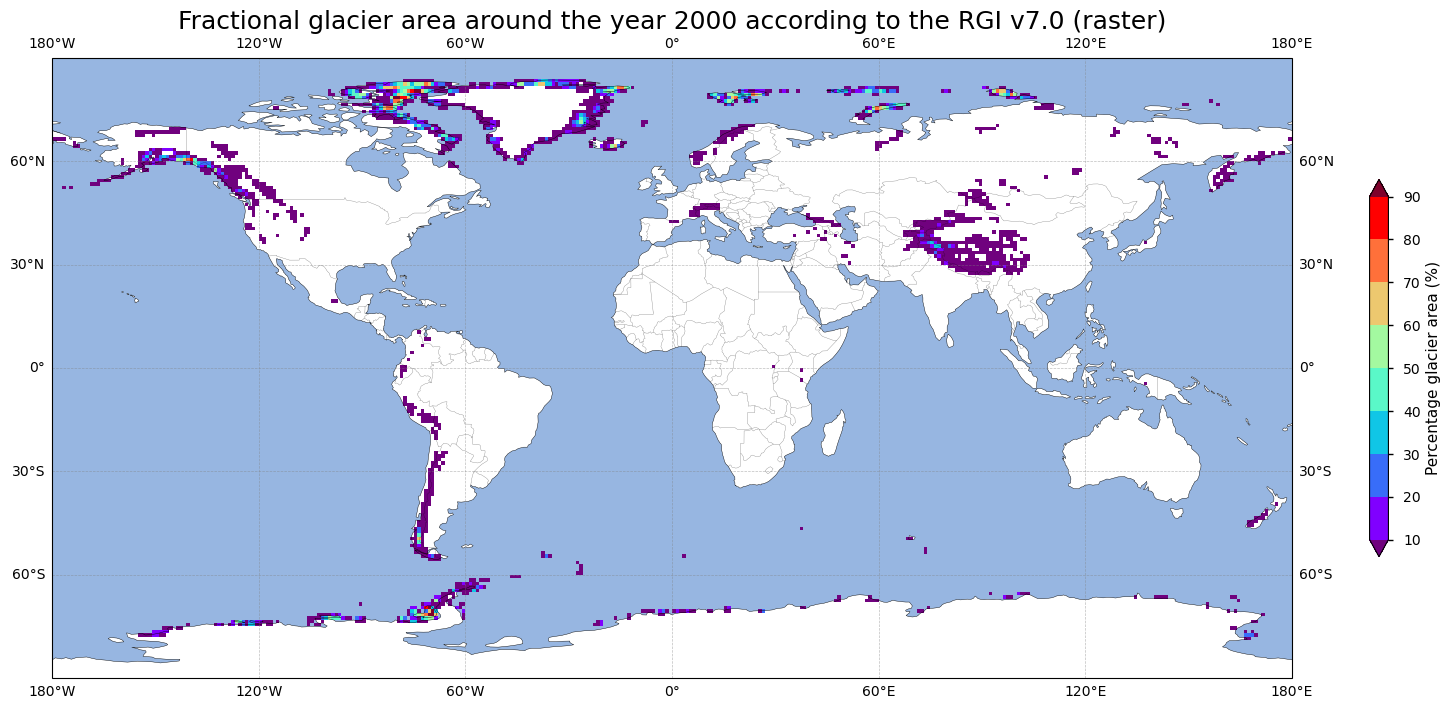

In [5]:
# Plot the gridded data
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
im=ax.pcolormesh(df2["longitude"].values, df2["latitude"].values, df2["Glacier_area"].values, transform=ccrs.PlateCarree(), cmap = mpl.cm.rainbow, norm = mpl.colors.BoundaryNorm(range(10, 100, 10), mpl.cm.rainbow.N))
im.cmap.set_over('#7E012B')
im.cmap.set_under('#70017E')
fig.colorbar(im,ax=ax,extend='both',shrink=0.49,label='Percentage glacier area (%)')
plt.title('Fractional glacier area around the year 2000 according to the RGI v{} (raster)'.format(rgi_version), fontsize=18)
plt.show()

*<center>Figure 1. Spatial distribution of the fractional glacier area in the raster version of the glacier extent dataset.</center>*

(section-2-2)=
#### 2.2 Pixel-by-pixel absolute glacierized area in the raster data

To calculate the total absolute glacier area from the raster product, we first need to find the surface area of a 1 by 1 degree pixel across the globe, which varies for each pixel (i.e. the surface area of a pixel gets smaller towards the poles). After multiplying those respective surface areas by the fractional glacier area of the corresponding pixel, and summing up all those values, we get an estimate of the total glacier surface area. We assume the Earth to be a sphere so that:

$
\sum\limits_{i=1}^n A_{\text{glacier}}
$
[km²]
$
= \sum\limits_{i=1}^n \left(\dfrac{1}{100} * \left(\dfrac{A_{\text{RGI},i}}{A_{\text{grid},i}}\right) * A_{\text{grid},i}\right)
$


where
$
\dfrac{A_{\text{RGI},i}}{A_{\text{grid},i}}
$
[%] is the fractional glacier area as given by the RGI raster product, and $n$ the total amount of glacier-covered pixels with a single pixel denoted as $i$, 

and
$
{A_{\text{grid},i}}
$
[km$^2$]
$
= (R * cos(\phi_i) * \Delta\Lambda_i) * (R \Delta\phi_i)
$
with
$
R
$
the radius of the Earth [km] and 
$
\Delta\Lambda
$
and
$
\Delta\phi
$
the change of longitude and latitude respectively [rad]. By integrating over all latitudes and longitudes, this formula yields the surface area of a sphere, i.e. $4 \pi R^2$.

Let us run this script:

In [6]:
def surf_area_on_sphere(lat0, lat1, delta_lon, r):
    d2r = np.pi / 180.
    return (r * np.cos(d2r*((lat1+lat0)/2))*(d2r * delta_lon))*(r * (d2r * (lat1-lat0)))

# Constants for Earth (in kilometers)
earth_radius = 6371.0  # in km

# Define latitude and longitude ranges
latitudes = np.arange(np.min(df2["latitude"].values), np.max(df2["latitude"].values+1), 1)  # Latitude range
longitudes = np.arange(np.min(df2["longitude"].values), np.max(df2["longitude"].values+1), 1)  # Longitude range

# Initialize variables to store total surface areas
surface_areas = np.zeros(np.shape(df2["Glacier_area"]))

# Calculate surface areas for each latitude and longitude
for i in range(len(latitudes) - 1):
    for j in range(len(longitudes) - 1):
        lat0 = latitudes[i]
        lat1 = latitudes[i + 1]
        delta_lon = longitudes[j + 1] - longitudes[j]

        # Calculate surface areas
        area_sphere = surf_area_on_sphere(lat0, lat1, delta_lon, earth_radius)
        
        # Store info
        surface_areas[i,j] = area_sphere

# Add surface area to xarray data
df2['Surface_area'] = (('latitude','longitude'),surface_areas)

# Calculate the total area covered by glaciers in the gridded dataset
total_area_gridded = np.nansum((df2["Surface_area"].values)*((df2["Glacier_area"].values)/100))
number_of_pixels = np.count_nonzero(~np.isnan(df2["Glacier_area"].values))

Now, we can finally print the total absolute glacier area from the raster format:

In [7]:
# Print relevant data
print( 
    f"A total number of {number_of_pixels} pixels (or {100*number_of_pixels/(len(latitudes)*len(longitudes)):.2f}%) hold glacier extent data in the raster dataset, "
    f"covering a total surface area of {total_area_gridded:.2f} km²."
)

A total number of 2096 pixels (or 3.42%) hold glacier extent data in the raster dataset, covering a total surface area of 714458.17 km².


Let us plot the absolute glacier area from the raster dataset on a world map:

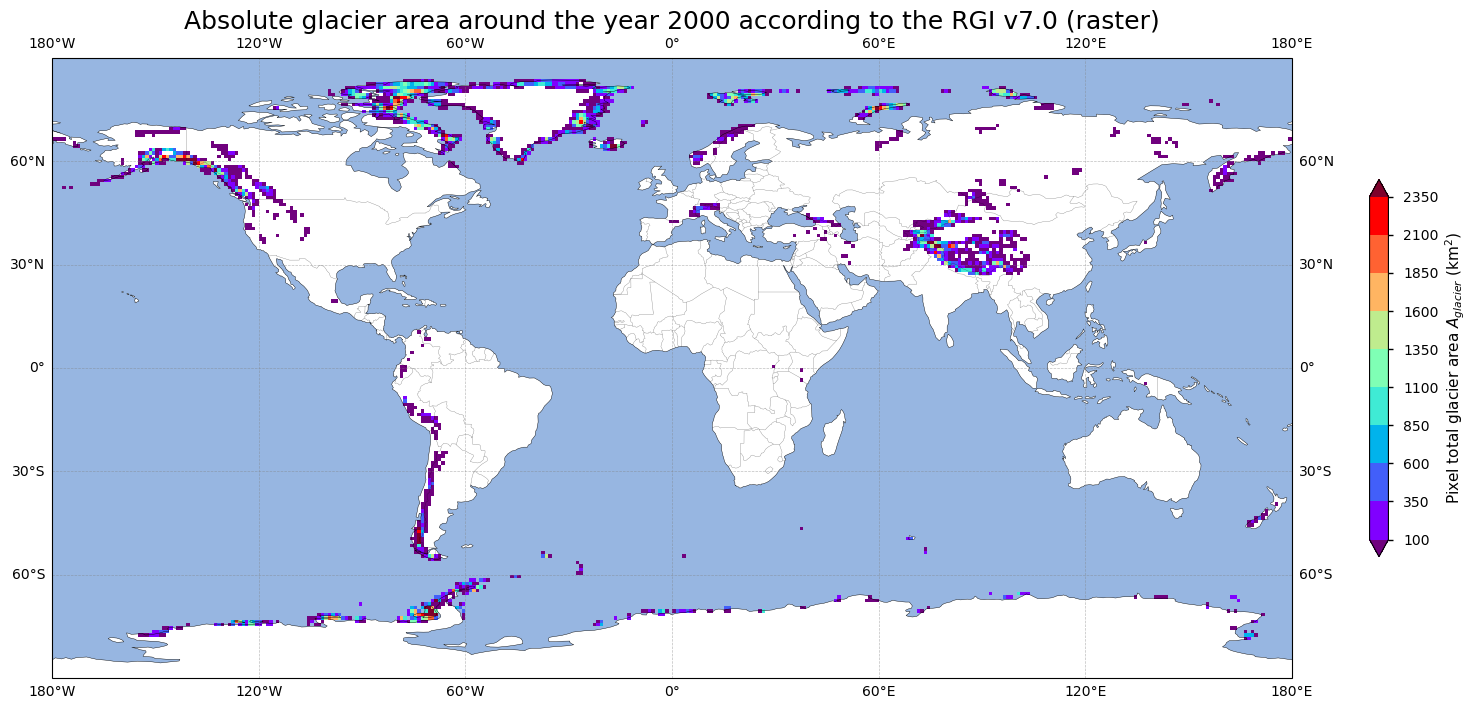

In [8]:
# Plot the gridded data
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
im=ax.pcolormesh(df2["longitude"].values, df2["latitude"].values, (((df2["Glacier_area"].values)/100)*df2["Surface_area"].values), transform=ccrs.PlateCarree(),  cmap = mpl.cm.rainbow, norm = mpl.colors.BoundaryNorm(range(100, 2600, 250), mpl.cm.rainbow.N))
fig.colorbar(im,ax=ax,extend='both',shrink=0.49,label='Pixel total glacier area $A_{glacier}$ (km$^2$)')
plt.title('Absolute glacier area around the year 2000 according to the RGI v{} (raster)'.format(rgi_version), fontsize=18)
plt.show()

*<center>Figure 2. Spatial distribution of the absolute glacier area in the raster version of the glacier extent dataset.</center>*

In order to compare this number with the vector version of the dataset, we turn to the vector format in the section below.

(section-2-3)=
#### 2.3 Individual glacier area in the vector data

Let us now inspect the vector product of the same dataset. We therefore plot the polygons (that each represent the outline of an individual glacier) as data points across the globe. Here, data are not aggregated in pixels but values thus represent the glacier area of individual glaciers. This results in the following:

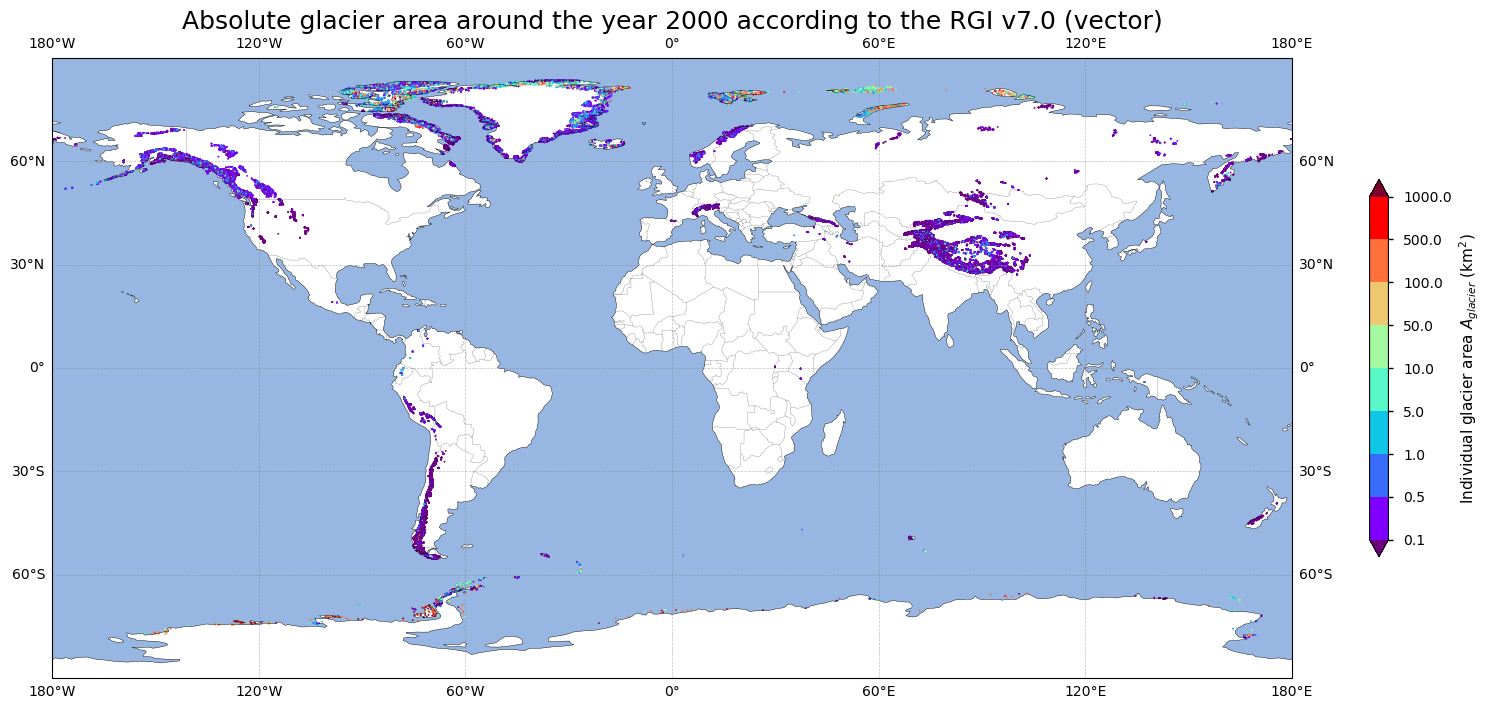

In [9]:
# Plot the gridded data
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND,color='w')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
cmap = mpl.cm.rainbow
norm = mpl.colors.BoundaryNorm((0.1,0.5,1,5,10,50,100,500,1000), cmap.N)
if rgi_version == 6.0:
    sc = ax.scatter(gdf['CENLON'], gdf['CENLAT'], c=gdf['AREA'], cmap=cmap, norm=norm, s=1, transform=ccrs.PlateCarree())
elif rgi_version == 7.0:
    sc = ax.scatter(gdf['cenlon'], gdf['cenlat'], c=gdf['area_km2'], cmap=cmap, norm=norm, s=1, transform=ccrs.PlateCarree())
fig.colorbar(sc, ax=ax, extend='both', shrink=0.49, label='Individual glacier area $A_{glacier}$ (km$^2$)')
plt.title('Absolute glacier area around the year 2000 according to the RGI v{} (vector)'.format(rgi_version), fontsize=18)
plt.show()

*<center>Figure 3. Spatial distribution of individual glaciers and their area in the vector version of the glacier extent dataset.</center>*

The geographical distribution of glaciers is similar to that of the raster product, although the vector product allows for more detailed and glacier-specific analysis. However, due to the different representation, the above two maps do not allow for an easy quantitative comparison of the glacier area between the two versions of the dataset. Let us therefore get the statistics of the vector version of the glacier extent data:

In [10]:
# Print relevant data
if rgi_version == 6.0:
    print( 
    f"A total number of {len(gdf)} glaciers is present in the dataset, "
    f"covering a total surface area of {gdf['AREA'].sum():.2f} km².")
elif rgi_version == 7.0:
    print( 
    f"A total number of {len(gdf)} glaciers is present in the dataset, "
    f"covering a total surface area of {gdf['area_km2'].sum():.2f} km².")

A total number of 274531 glaciers is present in the dataset, covering a total surface area of 706744.05 km².


This already reveals a slight difference between both data formats. With the above information in mind, we can now further quantify the total regional (according to the 19 RGI regions) glacier area and compare the values between the vector and raster version of the dataset more in-depth.

(section-3)=
### 3. Regional and global comparison of the vector and raster product

(section-3-1)=
#### 3.1 Quantification of global glacier area differences

This section presents a regional and global comparison of glacier areas derived from vector and raster data products of the glacier extent data from the Randolph Glacier Inventory version 7.0 (RGIv7.0). In doing so, discrepancies and agreements between the two data formats are analyzed, providing further insights into their consistency and usability for climatological and hydrological applications, such as water resource management. We first quantify the difference of the global total glacier area between both data formats:

$
\Delta A_{\text{glacier}}^{\text{global}}
$
[km$^2$]
$
= \sum\limits^{x,y} A_{\text{glacier}}^{\text{raster}} - \sum\limits^n A_{\text{glacier}}^{\text{vector}}
$

with $x,y$ all glacier-covered pixels in the raster product and $n$ the total amount of individual glaciers in the vector product. 

This results in:

In [11]:
# Calculate the total glacier area from the raster product
total_glacier_area_raster = np.nansum(((df2['Glacier_area'].values) / 100) * df2['Surface_area'].values)
# Calculate the total glacier area from the vector product
if rgi_version == 6.0:
    total_glacier_area_vector = gdf['AREA'].sum()
elif rgi_version == 7.0:
    total_glacier_area_vector = gdf['area_km2'].sum()
# Print the difference
print(
    f"The difference of the total global glacier area between the raster and the vector product is "
    f"{abs(total_glacier_area_raster - total_glacier_area_vector):.2f} km²."
)

The difference of the total global glacier area between the raster and the vector product is 7714.12 km².


(section-3-2)=
#### 3.2 Regional glacier area differences between raster and vector data

Let us analyse this regionally and check where the most significant differences are situated. For the vector data, we can easily extract the RGI regions, which are embedded in 'RGIID' for RGIv6.0 or stored in 'o1region' for RGIv7.0, and aggregate the glacier surface areas for each specific region. For the raster data, no RGI region is assigned to a certain pixel. Hence, a region mask has to be created at first.

For that, we first extract the glacier locations and their RGI region from the vector data. We then construct an array of glacier centroids, assigning each glacier center point (in latitude and longitude coordinates) to its region ID. Then we regrid this onto the target raster grid form the RGI raster data, using nearest-neighbour mapping. This produces a RGI region mask on the raster domain which was used to isolate all grid cells belonging to each RGI region. If multiple glaciers from different RGI regions fall within the same grid cell, the grid cell receives the region ID of whichever glacier centroid is closest. By multiplying glacierized grid-cell fractions with the corresponding cell surface areas and summing over each region, we obtained regionally aggregated glacier areas from the raster product. These raster-derived values were then directly compared to the vector-derived regional totals to evaluate discrepancies between the two datasets:

In [12]:
# Get the total regional glacier area from the vector product
if rgi_version == 6.0:
    gdf["region"] = gdf["RGIID"].str[6:8].astype(int)
    grouped = gdf[["AREA", "region"]].groupby("region")
    total_area = (grouped["AREA"].sum())

    # Get the total regional area from the raster product
    regions = gdf["RGIID"].str[6:8].astype(int)
    da = regions.to_xarray().assign_coords(
        lon=gdf["CENLON"].to_xarray(),
        lat=gdf["CENLAT"].to_xarray(),
    )
elif rgi_version == 7.0:
    gdf["region"] = gdf["o1region"].astype(int)
    grouped = gdf[["area_km2", "region"]].groupby("region")
    total_area = (grouped["area_km2"].sum())

    # Get the total regional area from the raster product
    regions = gdf["o1region"].astype(int)
    da = regions.to_xarray().assign_coords(
        lon=gdf["cenlon"].to_xarray(),
        lat=gdf["cenlat"].to_xarray(),
    )
regridder = xe.Regridder(da, df2, locstream_in=True, method="nearest_s2d")
mask_2d = regridder(da)
mask = xr.concat(
    [(mask_2d == region).expand_dims(region=[region]) for region in regions.unique()],
    "region",
)
df3 = df2.where(mask)
total_glacier_area_all_regions = (((df3["Glacier_area"] / 100) * df3["Surface_area"]).sum(dim=['latitude', 'longitude']))

Now we can finally plot the quantified regional differences of the glacier area between the vector and raster version of the data:

$
\Delta A_{\text{glacier}}^{\text{region}}
$
[km$^2$]
$
= \sum\limits^{x,y \in \text{region}} A_{\text{glacier}}^{\text{raster}} - \sum\limits^{n\in \text{region}} A_{\text{glacier}}^{\text{vector}}
$

or in percentage difference:

$
\Delta A_{\text{glacier}}^{\text{region}} 
$
[%] = 
$
\dfrac {100 * \left(\sum\limits^{x,y \in \text{region}} A_{\text{glacier}}^{\text{raster}} - \sum\limits^{n \in \text{region}} A_{\text{glacier}}^{\text{vector}}\right)}{\sum\limits^{n \in \text{region}} A_{\text{glacier}}^{\text{vector}}}
$

with $x,y$ all glacier-covered pixels in the raster product in a certain RGI region and $n$ the total amount of individual glaciers in the vector product in a certain RGI region. 

The calculations above result in the following:

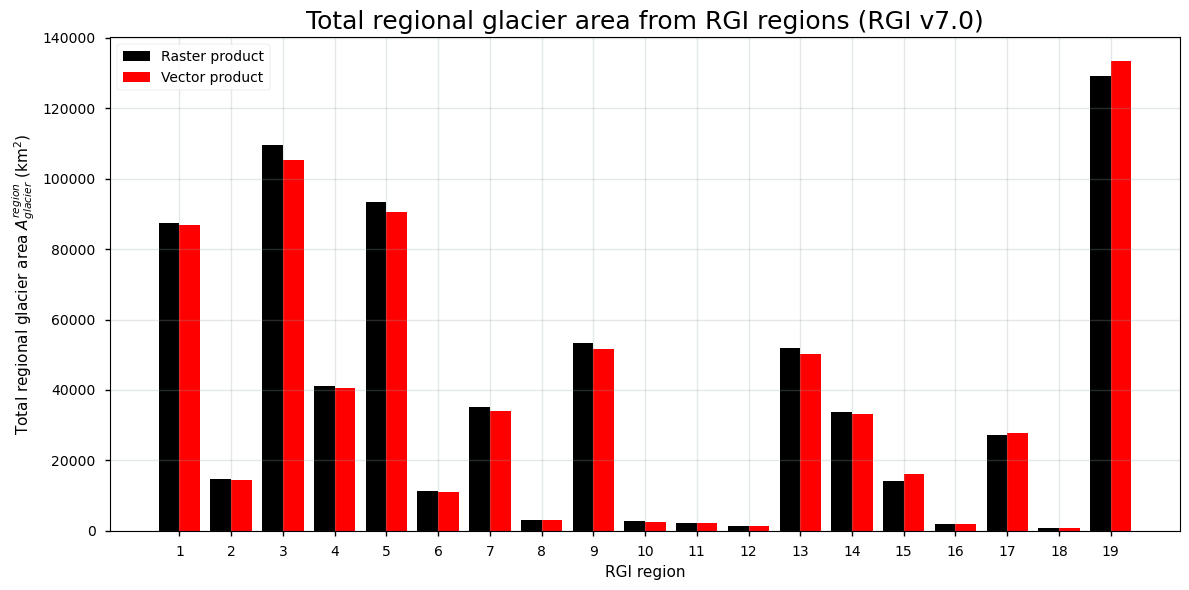

In [13]:
# Define regions and data
regions = np.arange(1, len(total_glacier_area_all_regions) + 1)  # Regions 1 to max(region)
raster_values = total_glacier_area_all_regions  # Raster product values
vector_values = total_area.values  # Vector product values
# Define bar width and positions
bar_width = 0.4
r1 = regions - bar_width / 2  # Positions for raster product bars
r2 = regions + bar_width / 2  # Positions for vector product bars
# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(r1, raster_values, width=bar_width, color='black', label='Raster product')
plt.bar(r2, vector_values, width=bar_width, color='red', label='Vector product')
# Add labels, title, and legend
plt.xlabel("RGI region")
plt.ylabel("Total regional glacier area $A^{region}_{glacier}$ (km$^{2}$)")
plt.title('Total regional glacier area from RGI regions (RGI v{})'.format(rgi_version), fontsize=18)
plt.xticks(regions)  # Set x-ticks to region numbers
plt.legend()
# Show grid and plot
plt.grid(color='#95a5a6', linestyle='-', alpha=0.25)
plt.tight_layout()
plt.show()

*<center>Figure 4. Regional comparison of the total absolute glacier area between the vector and raster version of the glacier extent dataset.</center>*

And to express it as a percentage difference:

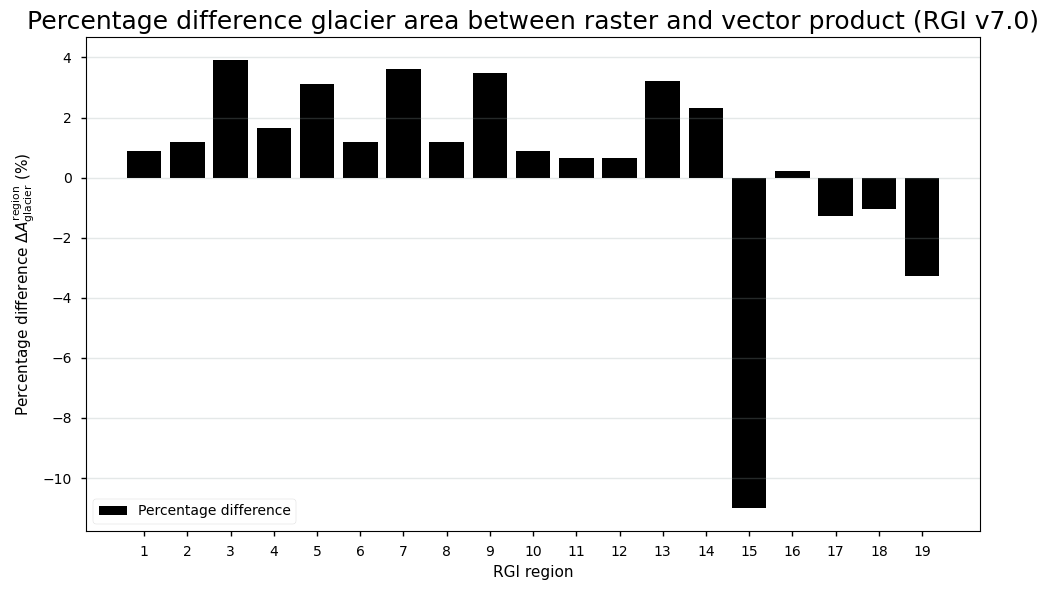

In [16]:
# Calculate the differences
differences = total_glacier_area_all_regions - total_area
percentage_differences = (100 * differences) / total_area
# Define regions
regions = np.arange(1, len(total_area) + 1)  # Generate regions as integers (1 to max)
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(regions, (percentage_differences), color='black', label="Percentage difference")
# Add labels, title, and grid
plt.xlabel("RGI region")
plt.ylabel(r"Percentage difference $\Delta A_{\mathrm{glacier}}^{\mathrm{region}}$ (%)")
plt.title('Percentage difference glacier area between raster and vector product (RGI v{})'.format(rgi_version), fontsize=18)
plt.grid(color='#95a5a6', linestyle='-', alpha=0.25, axis='y')  # Add grid only for y-axis
plt.xticks(regions)  # Ensure x-ticks match region numbers
plt.legend(loc="lower left")
# Show the plot
plt.tight_layout()
plt.show()

*Figure 5. Regional comparison of the percentage difference of glacier areas between the vector and raster version of the glacier extent dataset.*

The figures above compare the total regional glacier area from RGI regions using raster and vector products, and shows the percentage difference between these data formats. The percentage difference plot indicates that, while the vector product generally aligns with the raster product, significant percentage-wise discrepancies are observed in especially RGI region 15 (southern Asia/Himalaya), where the vector product shows notably higher absolute glacier areas. Most regions, however, exhibit low percentage differences (< 4%), suggesting good agreement. Let us also have these numbers quantified by text:

In [19]:
# Print values
for i, (value,perc) in enumerate(zip(differences,percentage_differences)):
    print(f"The glacier surface area in RGI region {i+1:>2} in the raster version "
          f"is {'under' if value < 0 else 'over':>5}estimated "
          f"by {np.abs(value):.2f} {'km²'} or {abs(perc):.2f}% when compared to the vector product.")

The glacier surface area in RGI region  1 in the raster version is  overestimated by 769.25 km² or 0.89% when compared to the vector product.
The glacier surface area in RGI region  2 in the raster version is  overestimated by 171.73 km² or 1.18% when compared to the vector product.
The glacier surface area in RGI region  3 in the raster version is  overestimated by 4134.28 km² or 3.92% when compared to the vector product.
The glacier surface area in RGI region  4 in the raster version is  overestimated by 673.93 km² or 1.66% when compared to the vector product.
The glacier surface area in RGI region  5 in the raster version is  overestimated by 2830.00 km² or 3.13% when compared to the vector product.
The glacier surface area in RGI region  6 in the raster version is  overestimated by 129.79 km² or 1.17% when compared to the vector product.
The glacier surface area in RGI region  7 in the raster version is  overestimated by 1225.13 km² or 3.61% when compared to the vector product.
The

The comparison between the raster and vector products of glacier area reveals varying degrees of overestimation and underestimation across different RGI regions when both data formats are compared to one another. Most regions show minor discrepancies, with the raster product generally under or overestimating glacier areas by small percentages. Notably, significant percentage-wise differences in RGI region 15 exist. The discrepancies and inconsistency of the calculated glacier area between the raster and vector versions of the Randolph Glacier Inventory data, especially in the southern Asian/Himalayan region, have been documented before [[3](https://doi.org/10.1017/jog.2021.28)] and can have significant implications for water resource management across various spatial scales. Accurate glacier area data are namely crucial for understanding glacier contributions to water supplies, especially in regions where glaciers play a key role in the hydrological cycle (such as the Himalaya) [[4](https://doi.org/10.3189/2013AoG63A296)].

![alternatvie text](https://www.glims.org/rgi_user_guide/_images/global_map_small.jpeg)

*Figure 6. The 19 first-order regions of the RGI version 7.0 and glacier locations in red. From: [GLIMS RGI](https://www.glims.org/rgi_user_guide/welcome.html).*

It must be noted that the comparison between the RGI 7.0 vector dataset and the raster-based data representation is affected by differences in how area is defined and computed in both datasets. In the RGI 7.0 data, glacier polygon areas are computed in their local UTM zone (corresponding to the centroid of each glacier), using the WGS84 reference ellipsoid. In contrast, in this notebook, the area of each 1° raster grid cell has been calculated assuming a perfect sphere. This difference introduces a latitude-dependent systematic offset. 

In this context, it is also important to acknowledge a limitation of the nearest-neighbour regridding approach used to construct the RGI region mask on the raster grid. Because each grid cell is assigned the region ID of the nearest glacier centroid, cells that contain (or lie close to) glaciers from multiple RGI regions inevitably receive only a single region label. This can lead to systematic misallocation of glacier area in regions where RGI boundaries overlap spatially within the coarse 1° by 1° raster cells. A prominent example is the Himalaya region, where regions 13, 14 and 15 border each other. In such cases, glacierized cells belonging to a certain region may be assigned to neighbouring regions simply because the nearest glacier centroid happens to lie across the regional boundary. 

Lastly, interpolation, reprocessing, and resampling likely have a less pronounced effect on these areal mismatches.

(section-4)=
### 4. Short summary and take-home messages

For the glacier area product to exhibit a high level of maturity and to be useful for glaciological and hydrological purposes, the raster and vector versions of the product should be consistent in terms of their glacier areas. The assessment in this notebook reveals that, overall, glacierized areas in both data formats agree relatively well with only minor percentage-wise differences. However, more significant percentage-wise discrepancies between the two data formats are present in some areas, which must be acknowledged by the user if the data are fed into glaciological or hydrological models. However, part of these differences may result from methodological choices in how regional glacier areas are computed in this notebook. First, the raster-based areas are calculated with a spherical Earth assumption, which is not fully consistent with the ellipsoidal geometry used for the vector-based area calculations in the RGI dataset. Second, the coarse grid resolution can cause neighbouring RGI regions to overlap within individual cells, leading to region misassignments when a region label is assigned via nearest‐neighbour mapping.

Both data formats furthermore share broader limitations, including potential digitization errors and challenges in identifying glacier outlines due to factors like supraglacial debris, shadows, and cloud cover [[4](https://doi.org/10.3189/2013AoG63A296)]. Users are advised to be cautious in regions that exhibit significant debris cover, small glaciers (i.e. relative errors are known to be higher for smaller glaciers due to their larger outline-to-area ratio [[2](https://doi.org/10.3189/2014JoG13J176)]), or around the peripheral glaciers of the Greenland and Antarctic ice sheets (where a clear separation of outlet glaciers from the main ice sheet body may be difficult). A last important sidenote is the fact that data cannot be used for temporal glacier area change or climate change impact assessment (it is a single snapshot in time). It is, for example, not possible to use the data for peak water discharge determination, as this would require (spatio-)temporal glacier area changes [[5](https://doi.org/10.1038/s41558-017-0049-x)].

As the primary goal of RGI is to provide consistent, static glacier outlines for climatological, hydrological, and glaciological applications at regional to global scales, both RGI data formats (vector and raster) can be used for such purposes. However, raster data are typically more practical due to its grid format, which allows for easier integration with other global datasets and into modelling efforts. These gridded RGI data are, however, presented as fractional glacier area data within a certain pixel (without a provided indication of the absolute surface area of the grid cell). The percentage values itself (i.e. the fractional glacierized areas) should be exact, but if absolute areas are requiered, the user should calculate these by themselves.

## ℹ️ If you want to know more

### Key resources

- [Glaciers distribution data from the Randolph Glacier Inventory (RGI) for year 2000](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview)
- [Documentation on the CDS](https://cds.climate.copernicus.eu/datasets/insitu-glaciers-extent?tab=overview) and the [ECMWF Confluence Wiki](https://confluence.ecmwf.int/display/CKB/Glacier+Area)
- [Copernicus climate change indicators: glaciers](https://climate.copernicus.eu/climate-indicators/glaciers)
- [RGI website from GLIMS](https://www.glims.org/RGI/) (Global Land Ice Measurements from Space)
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control` prepared by [B-Open](https://www.bopen.eu).

### References

- [[1](https://www.glims.org/RGI/randolph60.html)] RGI Consortium (2017). Randolph Glacier Inventory – A Dataset of Global Glacier Outlines: Version 6.0: Technical Report, Global Land Ice Measurements from Space, Colorado, USA. Digital Media. doi: 10.7265/N5-RGI-60.

- [[2](https://doi.org/10.3189/2014JoG13J176)] Pfeffer, W. T., Arendt, A. A., Bliss, A., Bolch, T., Cogley, J. G., Gardner, A. S., Hagen, J. O., Hock, R., Kaser, G., Kienholz, C., Miles, E. S., Moholdt, G., Mölg, N., Paul, F., Radić, V., Rastner, P., Raup, B. H., Rich, J., Sharp, M. J., and Glasser, N. (2014). The Randolph Glacier Inventory: A globally complete inventory of glaciers, Journal of Glaciology, 60(221), 537-552. doi: 10.3189/2014JoG13J176.

- [[3](https://doi.org/10.1017/jog.2021.28)] Li, Y. J., Li, F., Shangguan, D. H., Ding, Y. J. (2021). A New Global Gridded Glacier Dataset Based on the Randolph Glacier Inventory Version 6.0. Journal of Glaciology, 67 (2021), 773–76. doi: 10.1017/jog.2021.28.

- [[4](https://doi.org/10.3189/2013AoG63A296)] Paul, F., Barrand, N. E., Baumann, S., Berthier, E., Bolch, T., Casey, K., Frey, H., Joshi, S. P., Konovalov, V., Le Bris, R., Mölg, N., Nosenko, G., Nuth, C., Pope, A., Racoviteanu, A., Rastner, P., Raup, B., Scharrer, K., Steffen, S., and Winsvold, S. (2013). On the Accuracy of Glacier Outlines Derived from Remote-Sensing Data. Annals of Glaciology, 54(63), 171–82. doi: 10.3189/2013AoG63A296.

- [[5](https://doi.org/10.1038/s41558-017-0049-x)] Huss, M., and Hock, R. (2018). Global-scale hydrological response to future glacier mass loss, Nature Climate Change, 8, 135–140 (2018), doi: 10.1038/s41558-017-0049-x.